In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Fetching df from csv file

In [2]:
df = pd.read_csv('installments_payments.csv').sort_values(['SK_ID_PREV', 'DAYS_INSTALMENT'], ascending=True)

In [3]:
df.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
512588,1000001,158271,1.0,1,-268.0,-294.0,6404.310,6404.310
2159480,1000001,158271,2.0,2,-238.0,-244.0,62039.115,62039.115
1214732,1000002,101962,1.0,1,-1600.0,-1611.0,6264.000,6264.000
1631862,1000002,101962,1.0,2,-1570.0,-1575.0,6264.000,6264.000
3411021,1000002,101962,1.0,3,-1540.0,-1559.0,6264.000,6264.000


In [4]:
def group_observations_by_month(var):
    
    start_date = var.iloc[0] - 0.1
    end_date = var.iloc[-1] + 0.1
    
    # make bins using the first & last days, with 30 days interval
    my_bin = list(np.arange(start_date, 
                            end_date, 
                            30,
                            ))

    output_var = np.digitize(var,
                             bins = my_bin)
    
    return output_var

In [5]:
# assign month_group (i.e. 1st installation month, 2nd month...)
t1 = time.time()
df["month_group"] = df.groupby(["SK_ID_CURR", "SK_ID_PREV"])[["DAYS_INSTALMENT"]].transform(group_observations_by_month)
t2 = time.time()

In [6]:
(t2 - t1)/60

7.210018718242646

In [7]:
df_copy = df.copy()

## Feature Engineering

Might need to refer back to the original df now and then (while exploring), so all operations below are only done on a copy of the df

In [8]:
# how many rows are without payment?
# df_copy["IS_NA"] = df_copy["AMT_PAYMENT"].isnull()

In [9]:
# df_copy["IS_NA"].sum()

2905

In [10]:
# df_copy

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,month_group,IS_NA
512588,1000001,158271,1.0,1,-268.0,-294.0,6404.310,6404.310,1,False
2159480,1000001,158271,2.0,2,-238.0,-244.0,62039.115,62039.115,2,False
1214732,1000002,101962,1.0,1,-1600.0,-1611.0,6264.000,6264.000,1,False
1631862,1000002,101962,1.0,2,-1570.0,-1575.0,6264.000,6264.000,2,False
3411021,1000002,101962,1.0,3,-1540.0,-1559.0,6264.000,6264.000,3,False
...,...,...,...,...,...,...,...,...,...,...
11071524,2843499,314148,1.0,6,-1053.0,-1074.0,16074.000,16074.000,6,False
7680142,2843499,314148,1.0,7,-1023.0,-1047.0,16074.000,16074.000,7,False
9440302,2843499,314148,1.0,8,-993.0,-1018.0,16074.000,16074.000,8,False
9623305,2843499,314148,1.0,9,-963.0,-980.0,16074.000,16074.000,9,False


In [11]:
# Temporary flag: INSTALMENT_PAYMENT_EQUAL (AMT_INSTALMENT == AMT_PAYMENT) for each row
# Purpose see below
df_copy["INSTALMENT_PAYMENT_EQUAL_FLAG"] = np.where((df_copy["AMT_INSTALMENT"] == df_copy["AMT_PAYMENT"]), 1, 0)

In [13]:
df_grouped = df_copy.groupby(["SK_ID_CURR", 
                            "SK_ID_PREV", 
                            "month_group",
                           ])

In [15]:
df_month_level = df_grouped.agg({
    "DAYS_INSTALMENT" : np.mean,
    "DAYS_ENTRY_PAYMENT" : np.mean,
    "AMT_INSTALMENT": np.sum,
    "AMT_PAYMENT" : np.sum,
    "INSTALMENT_PAYMENT_EQUAL_FLAG": np.all,
    "IS_NA" : np.sum
})

In [16]:
# df_month_level[df_month_level["INSTALMENT_PAYMENT_EQUAL_FLAG"] == False]

DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
SK_ID_CURR SK_ID_PREV month_group                                        
100007     1940724    1                    -1076.0             -1090.0   
           2462742    10                   -1466.0             -1478.0   
                      12                   -1406.0             -1419.5   
100008     1907290    10                   -2029.0             -1384.0   
100011     1430602    9                    -2237.0             -2239.0   
...                                            ...                 ...   
456255     2631384    1                     -756.0              -768.0   
                      17                    -276.0              -287.0   
                      18                    -246.0              -254.5   
                      20                    -186.0              -201.5   
                      22                    -126.0              -141.5   

                                   AMT_INSTALMENT  AMT_PAYMENT  \
SK_ID_CURR SK_ID_PREV month_group                                
100007     1940724    1                 45357.570    22678.785   
           2462742    10                 7203.060     3601.530   
                      12                 7154.100     3577.050   
100008     1907290    10                23972.310    11986.155   
100011     1430602    9                 29228.670    14614.335   
...                                           ...          ...   
456255     2631384    1                669251.655  1338503.310   
                      17                54979.380    27489.690   
                      18                54979.380    27489.690   
                      20                54979.380    27489.690   
                      22                54979.380    27489.690   

                                   INSTALMENT_PAYMENT_EQUAL_FLAG  IS_NA  
SK_ID_CURR SK_ID_PREV month_group                                        
100007     1940724    1                                    False      0  
           2462742    10                                   False      0  
                      12                                   False      0  
100008     1907290    10                                   False      0  
100011     1430602    9                                    False      0  
...                                                          ...    ...  
456255     2631384    1                                    False      0  
                      17                                   False      0  
                      18                                   False      0  
                      20                                   False      0  
                      22                                   False      0  

[734646 rows x 6 columns]

In [ ]:
# IN THE ORIGINAL DATAFRAME...

# sometimes it is AMT_INSTALMENT columns that show the right amount a person is supposed to pay 
# (i.e. the TRUE AMT_INSTALMENT), BUT sometimes it is AMT PAYMENT column that shows the right amount...
# and sometimes it is the sum of multiple AMT_INSTALMENT rows that show the right amount

# in the initial group + aggregation above, we use sum of multiple AMT_INSTALMENT rows within same group, 
# but now need to modify this for some groups

# rule: if for the same group, AMT_INSTALMENT and AMT_PAYMENT has different values, take the max value within the group
# otherwise, take the sum of different rows within the same month group (i.e. value remains the same as above)...
# ... as TRUE AMT_INSTALMENT value

In [18]:
# modification according to the statement above
df_month_level["AMT_INSTALMENT"].mask(
    ((df_month_level["INSTALMENT_PAYMENT_EQUAL_FLAG"] == False) & (df_month_level["AMT_INSTALMENT"] < df_month_level["AMT_PAYMENT"])),
    df_month_level["AMT_PAYMENT"],
    inplace=True)

In [20]:
df_month_level_flattened = df_month_level.reset_index()

In [21]:
df_month_level_flattened["RATIO_PAID"] = df_month_level_flattened["AMT_PAYMENT"]/df_month_level_flattened["AMT_INSTALMENT"]

In [22]:
# convert na in DAYS_ENTRY_PAYMENT to 0
df_month_level_flattened['DAYS_ENTRY_PAYMENT'] = df_month_level_flattened['DAYS_ENTRY_PAYMENT'].fillna(0)

df_month_level_flattened["DAYS_LATE"] = df_month_level_flattened["DAYS_ENTRY_PAYMENT"] - df_month_level_flattened["DAYS_INSTALMENT"]

In [23]:
df_month_level_flattened["AMT_OWED"] = df_month_level_flattened["AMT_INSTALMENT"] - df_month_level_flattened["AMT_PAYMENT"]

In [63]:
df_prev_level_groups = df_month_level_flattened.groupby([
                     "SK_ID_CURR", 
                     "SK_ID_PREV",
                                  ])

# total payments and number of rows
df_prev_level = pd.DataFrame({
    "AMT_INSTALMENT_MEAN": df_prev_level_groups["AMT_INSTALMENT"].mean(),
    "AMT_PAYMENT_STD": df_prev_level_groups["AMT_PAYMENT"].std(),
    "NUMBER_OF_NA_ROWS": df_prev_level_groups["IS_NA"].sum(),
    "RATIO_PAID_STD": df_prev_level_groups["RATIO_PAID"].std(),
    "DAYS_LATE": df_prev_level_groups["DAYS_LATE"].mean(),
    "AMT_OWED": df_prev_level_groups["AMT_OWED"].sum(),
    "TOTAL_AMT_PAYMENT": df_prev_level_groups["AMT_PAYMENT"].sum(),
    # just pick an arbitrary column and get the count
})

In [64]:
df_prev_level["FRACTION_INSTALMENT_OWED"] = df_prev_level["AMT_OWED"] / df_prev_level["AMT_INSTALMENT_MEAN"]
df_prev_level = df_prev_level.drop(["AMT_INSTALMENT_MEAN"], axis=1)

In [65]:
df_prev_level["IS_LATE"] = np.where(df_prev_level["DAYS_LATE"] > 0, 1, 0)
df_prev_level = df_prev_level.drop(["DAYS_LATE"], axis=1)

In [66]:
default_conditions = (df_prev_level["NUMBER_OF_NA_ROWS"] >= 3) & \
             ((df_prev_level["AMT_OWED"] > 10000) | \
             (df_prev_level["FRACTION_INSTALMENT_OWED"] > 0.8))


df_prev_level["DEFAULT"] = default_conditions
df_prev_level["DEFAULT"] = np.where(df_prev_level["DEFAULT"] == True, 1, 0)

In [67]:
df_prev_level

AMT_PAYMENT_STD  NUMBER_OF_NA_ROWS  RATIO_PAID_STD  \
SK_ID_CURR SK_ID_PREV                                                       
100001     1369693         6723.450000                  0        0.000000   
           1851984            0.649519                  0        0.000000   
100002     1038818        10058.037722                  0        0.000000   
100003     1810518       174800.391505                  0        0.000000   
           2396755           21.460110                  0        0.000000   
...                                ...                ...             ...   
456255     1359084        13671.983860                  0        0.176777   
           1743609         6727.407358                  0        0.000000   
           2073384       134770.916638                  0        0.288675   
           2631384       271230.858033                  0        0.190347   
           2729207        18036.234771                  0        0.000000   

                        AMT_OWED  TOTAL_AMT_PAYMENT  FRACTION_INSTALMENT_OWED  \
SK_ID_CURR SK_ID_PREV                                                           
100001     1369693          0.00          29250.900                  0.000000   
           1851984          0.00          11945.025                  0.000000   
100002     1038818          0.00         219625.695                  0.000000   
100003     1810518          0.00        1150977.330                  0.000000   
           2396755          0.00          80773.380                  0.000000   
...                          ...                ...                       ...   
456255     1359084      11314.17         129183.570                  0.644234   
           1743609          0.00         132182.280                  0.000000   
           2073384      32801.22         282631.905                  0.311964   
           2631384     109958.76        2251553.805                  1.117508   
           2729207          0.00          65783.340                  0.000000   

                       IS_LATE  DEFAULT  
SK_ID_CURR SK_ID_PREV                    
100001     1369693           0        0  
           1851984           1        0  
100002     1038818           0        0  
100003     1810518           0        0  
           2396755           0        0  
...                        ...      ...  
456255     1359084           0        0  
           1743609           0        0  
           2073384           0        0  
           2631384           0        0  
           2729207           0        0  

[997752 rows x 8 columns]

In [69]:
#no_payment_conditions = (df_prev_level["TOTAL_AMT_PAYMENT"] == 0)

In [70]:
df_prev_level["NO_PAYMENT_FLAG"] = np.where(df_prev_level["TOTAL_AMT_PAYMENT"] == 0, 1, 0)

In [71]:
# df_prev_level

AMT_PAYMENT_STD  NUMBER_OF_NA_ROWS  RATIO_PAID_STD  \
SK_ID_CURR SK_ID_PREV                                                       
100001     1369693         6723.450000                  0        0.000000   
           1851984            0.649519                  0        0.000000   
100002     1038818        10058.037722                  0        0.000000   
100003     1810518       174800.391505                  0        0.000000   
           2396755           21.460110                  0        0.000000   
...                                ...                ...             ...   
456255     1359084        13671.983860                  0        0.176777   
           1743609         6727.407358                  0        0.000000   
           2073384       134770.916638                  0        0.288675   
           2631384       271230.858033                  0        0.190347   
           2729207        18036.234771                  0        0.000000   

                        AMT_OWED  TOTAL_AMT_PAYMENT  FRACTION_INSTALMENT_OWED  \
SK_ID_CURR SK_ID_PREV                                                           
100001     1369693          0.00          29250.900                  0.000000   
           1851984          0.00          11945.025                  0.000000   
100002     1038818          0.00         219625.695                  0.000000   
100003     1810518          0.00        1150977.330                  0.000000   
           2396755          0.00          80773.380                  0.000000   
...                          ...                ...                       ...   
456255     1359084      11314.17         129183.570                  0.644234   
           1743609          0.00         132182.280                  0.000000   
           2073384      32801.22         282631.905                  0.311964   
           2631384     109958.76        2251553.805                  1.117508   
           2729207          0.00          65783.340                  0.000000   

                       IS_LATE  DEFAULT  NO_PAYMENT_FLAG  
SK_ID_CURR SK_ID_PREV                                     
100001     1369693           0        0                0  
           1851984           1        0                0  
100002     1038818           0        0                0  
100003     1810518           0        0                0  
           2396755           0        0                0  
...                        ...      ...              ...  
456255     1359084           0        0                0  
           1743609           0        0                0  
           2073384           0        0                0  
           2631384           0        0                0  
           2729207           0        0                0  

[997752 rows x 9 columns]

In [72]:
df_prev_level_flattened = df_prev_level.reset_index()

In [73]:
df_curr_level_groups = df_prev_level_flattened.groupby(["SK_ID_CURR"])

In [74]:
df_curr_level = pd.DataFrame({
    "SK_ID_CURR": df_curr_level_groups["SK_ID_CURR"].first(),
    "AMT_PAYMENT_STD_MEAN": df_curr_level_groups["AMT_PAYMENT_STD"].mean(),
    "RATIO_PAYMENT_STD_MEAN": df_curr_level_groups["RATIO_PAID_STD"].mean(),
    "ANY_LATE": np.where(df_curr_level_groups["IS_LATE"].any(), 1, 0), 
    "ANY_DEFAULT": np.where(df_curr_level_groups["DEFAULT"].any(), 1, 0), 
    "ANY_NO_PAYMENT_FLAG": np.where(df_curr_level_groups["NO_PAYMENT_FLAG"].any(), 1, 0)
    
})

In [75]:
# df_curr_level

,SK_ID_CURR,AMT_PAYMENT_STD_MEAN,RATIO_PAYMENT_STD_MEAN,ANY_LATE,ANY_DEFAULT,ANY_NO_PAYMENT_FLAG
SK_ID_CURR,,,,,,
100001,100001,3362.049760,0.000000,1,0,0
100002,100002,10058.037722,0.000000,0,0,0
100003,100003,58313.693509,0.000000,0,0,0
100004,100004,3011.871810,0.000000,0,0,0
100005,100005,4281.015000,0.000000,0,0,0
...,...,...,...,...,...,...
456251,456251,2346.819209,0.000000,0,0,0
456252,456252,11.261529,0.000000,0,0,0
456253,456253,6.467152,0.083333,0,0,0


In [117]:
# can roughly split people into two groups: reliable and not-so-reliable??? 
# reliable people: no flag and small std values
# other people are not-so-reliable...

# default_conditions = (df_prev_level["NUMBER_OF_NA_ROWS"] >= 3) & \
#             ((df_prev_level["AMT_OWED"] > 10000) | \
#             (df_prev_level["FRACTION_INSTALMENT_OWED"] > 0.2))


# reliable customers: AMT_PAYMENT_STD_MEAN < 20000 or RATIO_PAYMENT_STD_MEAN < 0.1, 
#                     AND no flag

# Note aftermath: DISAPPOINTING, CAN IGNORE THIS VARIABLE

reliable_conditions = ((df_curr_level["AMT_PAYMENT_STD_MEAN"] < 20000) | \
             (df_curr_level["RATIO_PAYMENT_STD_MEAN"] < 0.1)) & \
             ((df_curr_level["ANY_LATE"] == 0) & \
              (df_curr_level["ANY_DEFAULT"] == 0) & \
              (df_curr_level["ANY_NO_PAYMENT_FLAG"] == 0)) 


df_curr_level["RELIABLE_CLIENT"] = reliable_conditions
df_curr_level["RELIABLE_CLIENT"] = np.where(df_curr_level["RELIABLE_CLIENT"] == True, 1, 0)

## Plot features

(array([3.22002e+05, 1.24090e+04, 2.74000e+03, 8.29000e+02, 2.89000e+02,
        1.15000e+02, 6.10000e+01, 3.80000e+01, 1.90000e+01, 1.00000e+01,
        5.00000e+00, 3.00000e+00, 5.00000e+00, 1.00000e+00, 3.00000e+00,
        2.00000e+00]),
 array([      0.,  100000.,  200000.,  300000.,  400000.,  500000.,
         600000.,  700000.,  800000.,  900000., 1000000., 1100000.,
        1200000., 1300000., 1400000., 1500000., 1600000.]),
 <BarContainer object of 16 artists>)

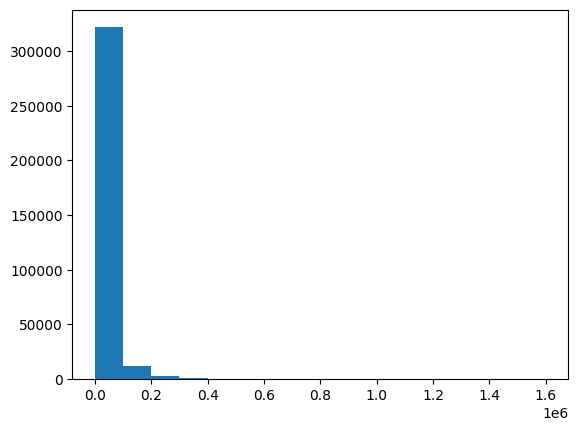

In [76]:
plt.hist(df_curr_level["AMT_PAYMENT_STD_MEAN"], bins=np.arange(0, 1.7e6, 1e5))

(array([2.80201e+05, 4.32730e+04, 1.47630e+04, 2.70000e+02, 1.50000e+01,
        7.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 <BarContainer object of 9 artists>)

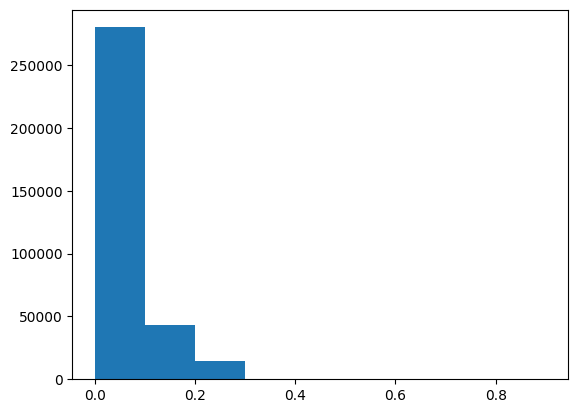

In [77]:
# RATIO_PAYMENT_STD_MEAN
plt.hist(df_curr_level["RATIO_PAYMENT_STD_MEAN"], bins=np.arange(0, 1, 0.1))

(array([313389.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  26198.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

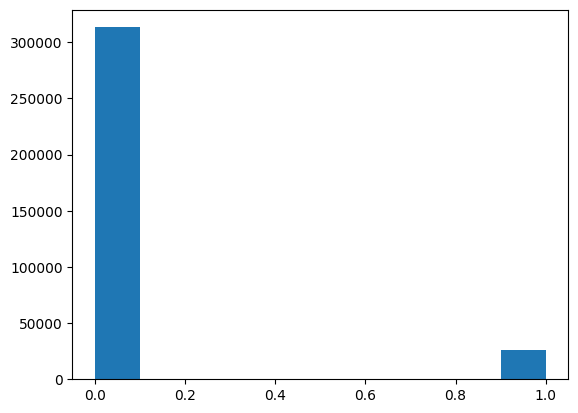

In [78]:
plt.hist(df_curr_level["ANY_LATE"])

(array([3.39423e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.64000e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

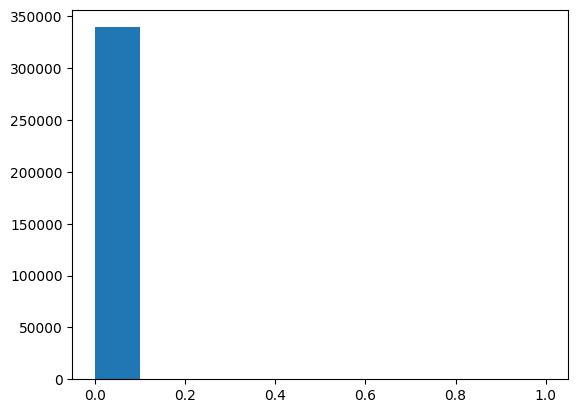

In [79]:
plt.hist(df_curr_level["ANY_DEFAULT"])

(array([3.39509e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 7.80000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

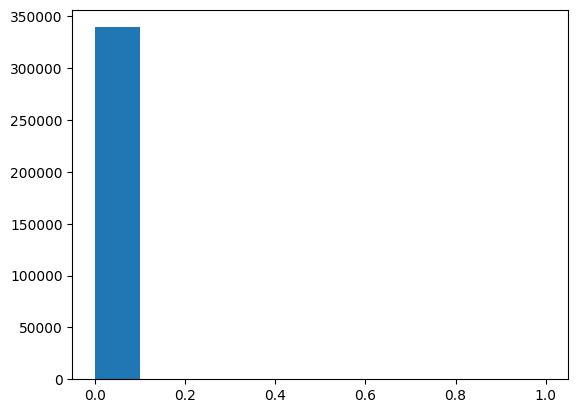

In [80]:
plt.hist(df_curr_level["ANY_NO_PAYMENT_FLAG"])

(array([ 35753.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 303834.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

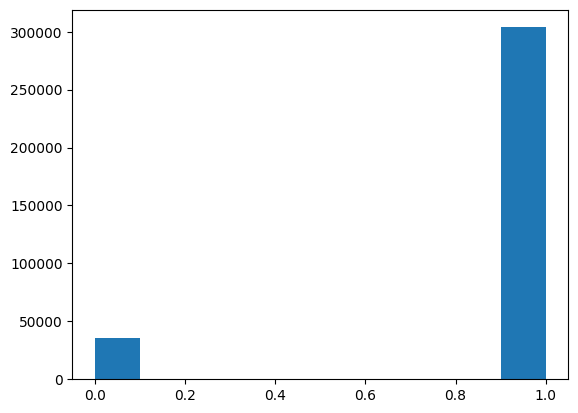

In [126]:
#1 means reliable, 0 means not reliable
plt.hist(df_curr_level["RELIABLE_CLIENT"])

## Univariate plots

Need to load the ground truth from application_train.csv

In [121]:
df_main = pd.read_csv('application_train.csv')

In [122]:
columns_needed = ["SK_ID_CURR", "TARGET"]
df_ground_truth = df_main[columns_needed]

In [123]:
df_curr_level.index.names = ['ID']

In [124]:
df_final = df_ground_truth.merge(df_curr_level, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

In [125]:
df_final[df_final["ANY_NO_PAYMENT_FLAG"] == 1]

,SK_ID_CURR,TARGET,AMT_PAYMENT_STD_MEAN,RATIO_PAYMENT_STD_MEAN,ANY_LATE,ANY_DEFAULT,ANY_NO_PAYMENT_FLAG,RELIABLE_CLIENT
10602,112352,0,3.660000,0.250000,1.0,0.0,1.0,0.0
11006,112813,1,19265.965219,0.044360,1.0,1.0,1.0,0.0
19702,122971,0,29.157548,0.117851,1.0,0.0,1.0,0.0
25878,130089,0,3881.019081,0.000000,1.0,1.0,1.0,0.0
26982,131362,0,71933.821635,0.000000,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
274804,418486,0,5115.785097,0.018286,1.0,1.0,1.0,0.0
274967,418699,0,16147.894524,0.072169,1.0,0.0,1.0,0.0
282223,426863,0,18.077234,0.000000,1.0,0.0,1.0,0.0
283757,428618,0,529.763168,0.111803,1.0,0.0,1.0,0.0


In [127]:
df_for_plotting = df_final.copy()

In [128]:
df_for_plotting["ANY_NO_PAYMENT_FLAG"] = np.where(df_for_plotting["ANY_NO_PAYMENT_FLAG"] == 1.0, '1', '0')
df_for_plotting["ANY_DEFAULT"] = np.where(df_for_plotting["ANY_DEFAULT"] == 1, '1', '0')
df_for_plotting["ANY_LATE"] = np.where(df_for_plotting["ANY_LATE"] == 1, '1', '0')
df_for_plotting["RELIABLE_CLIENT"] = np.where(df_for_plotting["RELIABLE_CLIENT"] == 1, '1', '0')

In [129]:
df_for_plotting

,SK_ID_CURR,TARGET,AMT_PAYMENT_STD_MEAN,RATIO_PAYMENT_STD_MEAN,ANY_LATE,ANY_DEFAULT,ANY_NO_PAYMENT_FLAG,RELIABLE_CLIENT
0,100002,1,10058.037722,0.000000,0,0,0,1
1,100003,0,58313.693509,0.000000,0,0,0,1
2,100004,0,3011.871810,0.000000,0,0,0,1
3,100006,0,2834.601883,0.000000,0,0,0,1
4,100007,0,35.835953,0.067792,1,0,0,0
...,...,...,...,...,...,...,...,...
307506,456251,0,2346.819209,0.000000,0,0,0,1
307507,456252,0,11.261529,0.000000,0,0,0,1
307508,456253,0,6.467152,0.083333,0,0,0,1
307509,456254,1,0.000000,0.000000,0,0,0,1


In [130]:
from sklearn.preprocessing import (
    KBinsDiscretizer,
)
import numpy as np
import matplotlib.pyplot as plt

def univariate_graph(data, var, path, rota = 45, **kwargs):
    '''
    This function takes at least a dataset and a variable name of the dataset. The variable name should be the feature you are looking at.
    It then groups by the variable values and calculates the amount of observations in the variable's categories and the percentage of 
    defaults in each category. If your variable is not categorical, it takes on an extra argument, n_bins, to make it categorical. Also 
    specify the strategy argument for the KBinsDiscretizer.
    The outcome of the variable is a plot that shows the amount of observations in each bucket as bars and the share of defaults as a line.
    '''
    df = data[['TARGET', var]].dropna().copy().reset_index(drop = True)
    if (type(df.loc[0, var]) is str) or (df[var].nunique() <= 10):
        df = df.groupby(var).agg({
            'TARGET' : [np.mean, len], 
            })
    else:
        df[var] = KBinsDiscretizer(**kwargs, 
                                   encode = 'ordinal',
                                   strategy = 'uniform'
                                  ).fit_transform(df[[var]])
        df[var] = [str(d) for d in df[var]]
        df = df.groupby(var).agg({
            'TARGET' : [np.mean, len],
            })
        
#     make graph
    fig, ax1 = plt.subplots()
    ax1.set_title(var.replace('_', ' '))
#     bar plot
    ax1.tick_params(axis = 'x', 
                    rotation = rota,
                   )
    ax1.set_ylabel('Anzahl', 
                   color = 'blue',
                  )
    ax1.bar(list(df.index),
            list(df['TARGET']['len']),
            label = 'Anzahl',
            color = 'blue',
            )
    ax1.tick_params(axis = 'y', 
                    labelcolor = 'blue',
                   ) 
#     line graph
    ax2 = ax1.twinx() 
    ax2.set_ylabel('Ausfallquote', 
                   color = 'red',
                   ) 
    ax2.plot(df['TARGET']['mean'],
             label = 'Ausfallquote', 
             color = 'red',
             ) 
    ax2.tick_params(axis = 'y', 
                    labelcolor = 'red') 
#     save figure
    plt.savefig(path+var+'.png')
#     show plot
    # plt.show() 

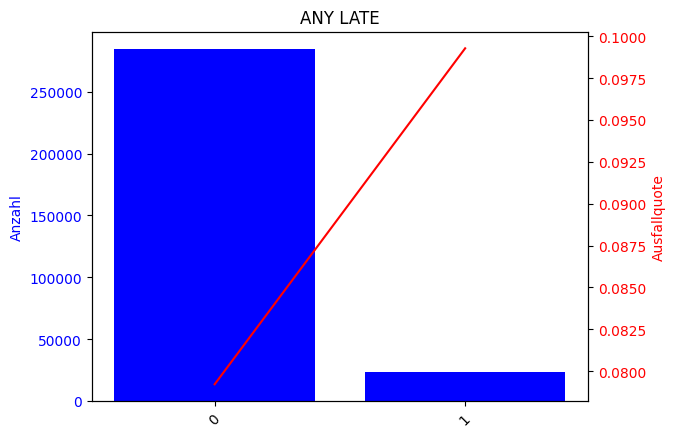

In [109]:
univariate_graph(df_for_plotting, 'ANY_LATE', "")

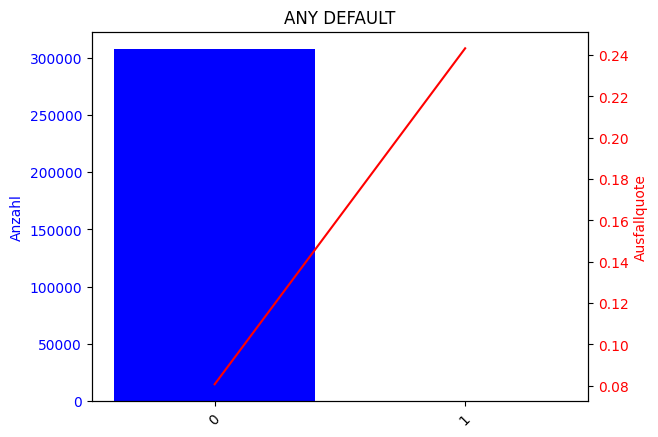

In [110]:
univariate_graph(df_for_plotting, 'ANY_DEFAULT', "")

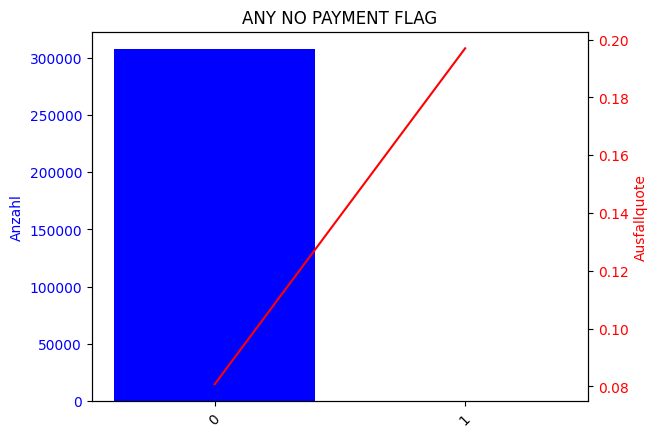

In [111]:
univariate_graph(df_for_plotting, 'ANY_NO_PAYMENT_FLAG', "")

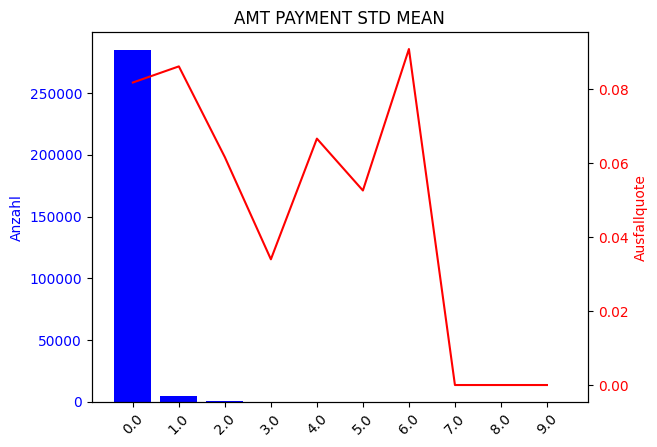

In [115]:
univariate_graph(df_for_plotting, 'AMT_PAYMENT_STD_MEAN', "", n_bins = 10)

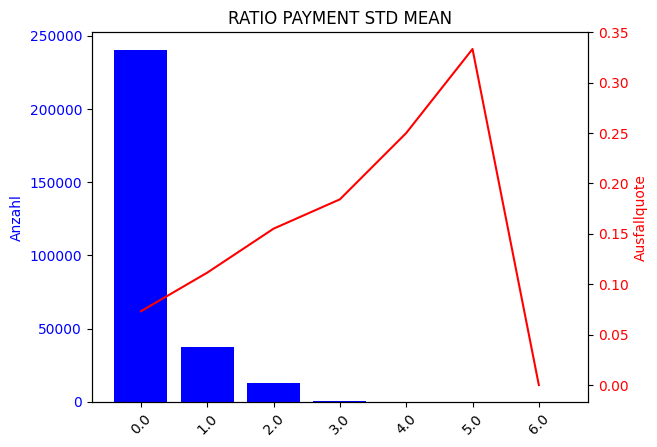

In [153]:
# THIS MIGHT BE INTERESTING TOO, BUT RUNNING OUT OF TIME
univariate_graph(df_for_plotting, 'RATIO_PAYMENT_STD_MEAN', "", n_bins = 7)

In [154]:
# print(len(df_final[df_final["RATIO_PAYMENT_STD_MEAN"]] > 0.6))

KeyError: "None of [Float64Index([                0.0,                 0.0,                 0.0,\n                              0.0, 0.06779246066755744, 0.03952847075210474,\n                              0.0,                 0.0,  0.1617723844127865,\n              0.10882647641691985,\n              ...\n                              0.0,                 0.0,                 0.0,\n              0.08606629658238706,                 0.0,                 0.0,\n                              0.0, 0.08333333333333333,                 0.0,\n              0.13776351492736055],\n             dtype='float64', length=307511)] are in the [columns]"

In [152]:
# print(min(df_for_plotting['RATIO_PAYMENT_STD_MEAN']), max(df_for_plotting['RATIO_PAYMENT_STD_MEAN']))

#bins = np.arange(min(df_for_plotting['RATIO_PAYMENT_STD_MEAN']), max(df_for_plotting['RATIO_PAYMENT_STD_MEAN']), )

0.0 0.7051905026467465


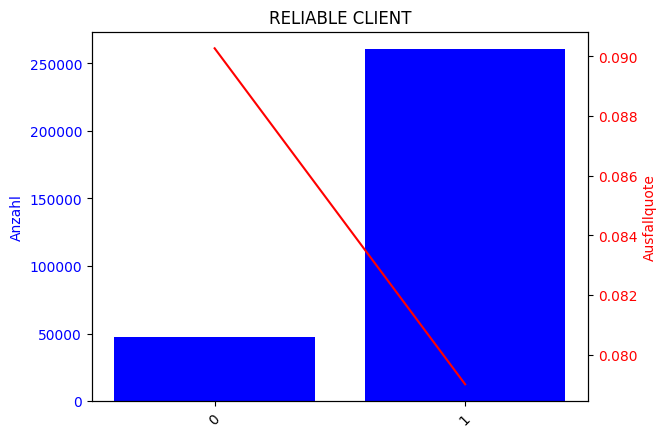

In [131]:
# further group people into final 2 groups...
univariate_graph(df_for_plotting, 'RELIABLE_CLIENT', "")

From the univariate plots above, only ANY_DEFAULT and ANY_NO_PAYMENT_FLAG shows promising results.
Due to time constraint, can simply use these two columns or combine them together into another single column

In [132]:
# combine the two columns, ANY_DEFAULT and ANY_NO_PAYMENT_FLAG into one column
df_final['DEFAULT_OR_NO_PAYMENT'] = np.where(((df_final["ANY_NO_PAYMENT_FLAG"] == 1) | (df_final["ANY_DEFAULT"] == 1)), 1, 0)

In [133]:
df_final

,SK_ID_CURR,TARGET,AMT_PAYMENT_STD_MEAN,RATIO_PAYMENT_STD_MEAN,ANY_LATE,ANY_DEFAULT,ANY_NO_PAYMENT_FLAG,RELIABLE_CLIENT,DEFAULT_OR_NO_PAYMENT
0,100002,1,10058.037722,0.000000,0.0,0.0,0.0,1.0,0
1,100003,0,58313.693509,0.000000,0.0,0.0,0.0,1.0,0
2,100004,0,3011.871810,0.000000,0.0,0.0,0.0,1.0,0
3,100006,0,2834.601883,0.000000,0.0,0.0,0.0,1.0,0
4,100007,0,35.835953,0.067792,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
307506,456251,0,2346.819209,0.000000,0.0,0.0,0.0,1.0,0
307507,456252,0,11.261529,0.000000,0.0,0.0,0.0,1.0,0
307508,456253,0,6.467152,0.083333,0.0,0.0,0.0,1.0,0
307509,456254,1,0.000000,0.000000,0.0,0.0,0.0,1.0,0


In [137]:
df_for_plotting["DEFAULT_OR_NO_PAYMENT"] = np.where(((df_for_plotting["ANY_NO_PAYMENT_FLAG"] == '1') | (df_for_plotting["ANY_DEFAULT"] == '1')), '1', '0')

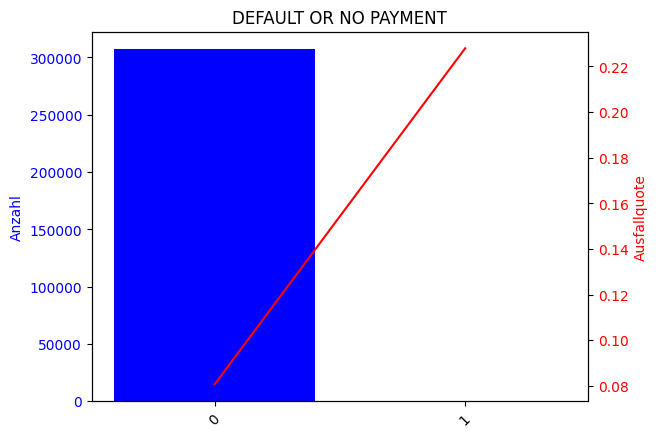

In [138]:
univariate_graph(df_for_plotting, 'DEFAULT_OR_NO_PAYMENT', "")

In [140]:
len(df_for_plotting[df_for_plotting["DEFAULT_OR_NO_PAYMENT"] == '1'])

193

In [ ]:
columns_needed_here = ["SK_ID_CURR", "DEFAULT_OR_NO_PAYMENT"]
df_FINAL = df_final[columns_needed_here]